# Changes

Ok adding batchnorm inbetween conv layer in the conv block:

`0.0639`

We should stop evaluating on the LB and start using a valdation set (maybe 10%).  Valdation sets for more hyperparameter tuning.

ok I did that, the result:

```
training epoch 50, epoch loss 0.0648319631030685
training epoch 50, epoch valid loss 0.02566206455230713
lowest loss: 0.0648319631030685
```

Try upsampling instead of deconvolution:

```
training epoch 50, epoch loss 0.06474896794871281
training epoch 50, epoch valid loss 0.024225905537605286
lowest loss: 0.06474896794871281
```

seems slightly better.

Adding dropout between layer in conv_block_drop in the up layers:


```
nn.BatchNorm2d(in_chan),
nn.Conv2d(in_chan, out_chan, 3, padding=1),
nn.ReLU(inplace=True),
nn.Dropout(p=drop),
nn.Conv2d(out_chan, out_chan, 3, padding=1),
nn.ReLU(inplace=True)
...
self.up2 = conv_up_drop(256, 128, 0.25)
self.up3 = conv_up_drop(128, 64, 0.20)
self.up4 = conv_up_drop(64, 32, 0.15)
self.up5 = conv_up_drop(32, 16, 0.10)
self.up6 = conv_up_drop(16, 8, 0.05)
```

increase test predictions to: 3077

Adding data aug:

```
transforms.RandomRotation(30),
transforms.Grayscale()


training epoch 30, epoch loss 0.08397911489009857
training epoch 30, epoch valid loss 0.11702423989772796

----

transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
transforms.Grayscale(),
    
training epoch 25, epoch loss 0.0671462985245805
training epoch 25, epoch valid loss 0.14574656188488005

----

transforms.RandomRotation(30),
transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
transforms.Grayscale(),

training epoch 25, epoch loss 0.14163307178961604
training epoch 25, epoch valid loss 0.18473265171051026

```


Try all intepolation methods, pick one that craetes the most test lines (maybe compare LB):

```
Image.BICUBIC - 2561
Image.BILINEAR - 2554
PIL.Image.LANCZOS - 2565
PIL.Image.NEAREST - 2568

they all otuput similar #s. probably will stick with BICUBIC.

```

trying a new metric:

```
 bce_ = bce()
dl = DiceLoss()
input, target = input.view(-1), target.view(-1)
return bce_(input, target) + dl(input, target)
```, 50 epochs

result:

training epoch 50, epoch loss 0.1555730104446411


Adding F.sigmoid to the inputs os that loss function:

terrible:

training epoch 15, epoch loss 1.3998216617675054


Try to shuffle:

lowest train loss: 0.17744959677968705

shange beta 0.5 -> 0.9:

`training epoch 50, epoch loss 0.16057119873308`

512, extra layer:

training epoch 45, epoch loss 0.16176933653297879
training epoch 50, epoch loss 0.18938866896288736

removing grayscale, 3 color channels:

training epoch 45, epoch loss 0.1721066041361718
training epoch 50, epoch loss 0.2183511597769601

# Setup

In [1]:
import os
from utils import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils import data
from torch.autograd import Variable, Function

from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

from PIL import Image
import numpy as np
import pandas as pd
from skimage.morphology import label
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
torch.backends.cudnn.benchmark = True

# Constants

In [2]:
BATCH_SIZE = 16
DATA_PATH = '/home/yvan/projects/data_sci_bowl_2018/data'
N_EPOCHS = 50
FILTER_DEPTH = 3
IMG_SIZE = 512
LR = 0.001

# Re-creating datasets

In [3]:
# create a train, test, validation datasets
convert_raw_train(folder_name='stage1_train', 
                  make_valid=False,
                  rand_state=75)
convert_raw_test(folder_name='stage1_test', folder_new='test_img')
dir_contents = [os.listdir(os.path.join(DATA_PATH, 'train_img', 'all')), os.listdir(os.path.join(DATA_PATH, 'valid_img', 'all'))]
list(map(len, dir_contents))

[670, 0]

# Data Processing

For building datagen that can handle transforms. 

https://github.com/pytorch/vision/issues/9

In [4]:
#create a custom imageloader that gets the name of the file as well
class YvanImageFolder(ImageFolder):
    def __getitem__(self,index):
        return super(YvanImageFolder, self).__getitem__(index), self.imgs[index]
    
class YvanDataset(data.Dataset):
    '''
    dataset wrapping image folders can't use default because 
    we need to load and transform target masks for segmentation!
    '''
    def __init__(self, img_path, target_path, transform=None, transform_target=None):
        self.imgs = sorted(glob.glob(os.path.join(img_path, '**/*.jpg')))
        self.targets = sorted(glob.glob(os.path.join(target_path, '**/*.jpg')))
        self.transform = transform
        self.transform_target = transform_target
        
    def __getitem__(self, index):
        img = Image.open(self.imgs[index])
        target = Image.open(self.targets[index])
        
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        np.random.seed(seed) 
        if self.transform:
            img = self.transform(img)
        np.random.seed(seed) 
        if self.transform_target:
            target = self.transform_target(target)
            
        return img, target, self.imgs[index], self.targets[index]
    
    def __len__(self):
        return len(self.imgs)
        
# train data
img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
#     transforms.Grayscale(),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
#     transforms.Grayscale(),
    transforms.ToTensor()
])

img_dataset = YvanDataset(os.path.join(DATA_PATH, 'train_img'),
                              os.path.join(DATA_PATH,'train_mask'),
                              transform=img_transform,
                              transform_target=target_transform)
img_loader = data.DataLoader(dataset=img_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)

for (img, mask, name, target_name) in img_loader:
    a,b,name,target_name = img[3], mask[3], name[3], target_name[3]
    print(name, target_name)
    print(type(a),type(b))
    print(a.size(), b.size())
    print(torch.max(a[0]), torch.min(a[0]), torch.max(b[0]), torch.min(b[0]))
    timg = transforms.ToPILImage()(a.cpu())
    tmask = transforms.ToPILImage()(b.cpu())
    break

/home/yvan/projects/data_sci_bowl_2018/data/train_img/all/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed_img.jpg /home/yvan/projects/data_sci_bowl_2018/data/train_mask/all/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed_mask.jpg
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
torch.Size([3, 512, 512]) torch.Size([3, 512, 512])
0.8588235378265381 0.24313725531101227 1.0 0.0


In [5]:
valid_dataset = YvanDataset(os.path.join(DATA_PATH, 'valid_img'),
                              os.path.join(DATA_PATH,'valid_mask'),
                              transform=img_transform,
                              transform_target=target_transform)
valid_loader = data.DataLoader(dataset=valid_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)

for (img, mask, name, target_name) in valid_loader:
    a,b,name,target_name = img[3], mask[3], name[3], target_name[3]
    print(name, target_name)
    print(type(a),type(b))
    print(a.size(), b.size())
    print(torch.max(a[0]), torch.min(a[0]), torch.max(b[0]), torch.min(b[0]))
    timg = transforms.ToPILImage()(a.cpu())
    tmask = transforms.ToPILImage()(b.cpu())
    break

# Unet model

referenced: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

conv visualized: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

In [6]:
### conv building block ###

class conv_block(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_chan),
            nn.Conv2d(in_chan, out_chan, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_chan, out_chan, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
class conv_block_drop(nn.Module):
    def __init__(self, in_chan, out_chan, drop):
        super(conv_block_drop, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_chan),
            nn.Conv2d(in_chan, out_chan, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=drop),
            nn.Conv2d(out_chan, out_chan, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

### inputs and outputs ###

class in_conv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(in_conv, self).__init__()
        self.bn = nn.BatchNorm2d(in_chan)
        self.conv = conv_block(in_chan, out_chan)
        
    def forward(self, x):
        return self.conv(self.bn(x))
        
class out_conv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(out_conv, self).__init__()
        self.bn = nn.BatchNorm2d(in_chan)
        self.conv = nn.Conv2d(in_chan, out_chan, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        return self.activation(self.conv(self.bn(x)))
    
### actual con blocks ###

class conv_down(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_down, self).__init__()
        self.pool_conv = nn.Sequential(
            conv_block(in_chan, out_chan),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.pool_conv(x)
        return x

class conv_up(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_up, self).__init__()
        self.conv_up = nn.ConvTranspose2d(in_chan, out_chan, 2, stride=2)
        self.conv = conv_block(2*out_chan, out_chan)
        self.bn = nn.BatchNorm2d(in_chan)
    
    def forward(self, x1, x2):
        x1 = self.bn(x1)
        x1 = self.conv_up(x1)
        x = torch.cat([x2,x1],dim=1)
        x = self.conv(x)
        return x

class conv_up_drop(nn.Module):
    def __init__(self, in_chan, out_chan, drop):
        super(conv_up_drop, self).__init__()
        self.conv_up = nn.ConvTranspose2d(in_chan, out_chan, 2, stride=2)
        self.conv = conv_block_drop(2*out_chan, out_chan, drop)
        self.bn = nn.BatchNorm2d(in_chan)
    
    def forward(self, x1, x2):
        x1 = self.bn(x1)
        x1 = self.conv_up(x1)
        x = torch.cat([x2,x1],dim=1)
        x = self.conv(x)
        return x
    
class conv_upsample(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(conv_upsample, self).__init__()
        self.conv_up = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv = conv_block(out_chan+in_chan, out_chan)
        self.bn = nn.BatchNorm2d(in_chan)
    
    def forward(self, x1, x2):
        x1 = self.bn(x1)
        x1 = self.conv_up(x1)
        x = torch.cat([x2,x1],dim=1)
        x = self.conv(x)
        return x

class unet1(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(unet1, self).__init__()
        self.inc = in_conv(in_chan, 8)
        self.down0 = conv_down(8, 16)
        self.down1 = conv_down(16, 32)
        self.down2 = conv_down(32, 64)
        self.down3 = conv_down(64, 128)
        self.down4 = conv_down(128, 256)
        self.down5 = conv_down(256, 512)
        self.up1 = conv_up(512, 256)
        self.up2 = conv_up(256, 128)
        self.up3 = conv_up(128, 64)
        self.up4 = conv_up(64, 32)
        self.up5 = conv_up(32, 16)
        self.up6 = conv_up(16, 8)
        self.out = out_conv(8, out_chan)
        
    def forward(self, x):
        xn = self.inc(x)
        x0 = self.down0(xn)
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.up5(x, x0)
        x = self.up6(x, xn)
        x = self.out(x)
        return x
    
def weights_init(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.xavier_uniform(m.weight, gain=np.sqrt(2))
        nn.init.constant(m.bias,0.0)
    elif type(m) == nn.BatchNorm2d:
        m.weight.data.uniform_(1.0,0.02)
        m.bias.data.zero_()

In [7]:
# create a unet
unet = unet1(FILTER_DEPTH, FILTER_DEPTH)
unet.apply(weights_init)
opti = optim.Adam(unet.parameters(), lr=LR, betas=(0.5,0.99))
loss = BCEDiceLoss()

nparams = sum([param.nelement() for param in unet.parameters()])
psum = check_param_sum(unet)
print(f'creating model with {nparams} params and intial param sum {psum}')

if torch.cuda.is_available():
    unet.cuda()
    loss.cuda()

losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    epoch_loss = []
    e = epoch+1
    for (batch, mask_batch, _, _) in img_loader:
        image_batch = to_variable(batch)
        labels = to_variable(mask_batch)
        
        x = unet(image_batch)
        l = loss(x, labels)
        epoch_loss.append(l.data[0])
        l.backward()
        opti.step()
        unet.zero_grad()
    
    mean_epoch_loss = np.mean(epoch_loss)
    losses.append(mean_epoch_loss)
    
    valid_loss = []
    for (batch, mask_batch, _, _) in valid_loader:
        image_batch = to_variable(batch)
        labels = to_variable(mask_batch)
        for p in unet.parameters():
            p.requires_grad = False
        x = unet(image_batch)
        
        vl = loss(x, labels)
        for p in unet.parameters():
            p.requires_grad = True
        valid_loss.append(vl.data[0])
        
    mean_valid_loss = np.mean(valid_loss)
    valid_losses.append(mean_valid_loss)
    
    if not e % 5: 
        print(f'training epoch {e}, epoch loss {mean_epoch_loss}')
        print(f'training epoch {e}, epoch valid loss {mean_valid_loss}')
    epoch_loss = []
    valid_loss = []

creating model with 7784471 params and intial param sum 1308.2527496516705


/home/yvan/anaconda3/envs/data_sci_bowl_2018/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yvan/anaconda3/envs/data_sci_bowl_2018/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


training epoch 5, epoch loss 0.7109638920852116
training epoch 5, epoch valid loss nan
training epoch 10, epoch loss 0.37701340090660823
training epoch 10, epoch valid loss nan
training epoch 15, epoch loss 0.26204821644794374
training epoch 15, epoch valid loss nan
training epoch 20, epoch loss 0.23585129458279835
training epoch 20, epoch valid loss nan
training epoch 25, epoch loss 0.2163687419323694
training epoch 25, epoch valid loss nan
training epoch 30, epoch loss 0.22380744417508444
training epoch 30, epoch valid loss nan
training epoch 35, epoch loss 0.19265252919424147
training epoch 35, epoch valid loss nan
training epoch 40, epoch loss 0.18438444428500675
training epoch 40, epoch valid loss nan
training epoch 45, epoch loss 0.1721066041361718
training epoch 45, epoch valid loss nan
training epoch 50, epoch loss 0.2183511597769601
training epoch 50, epoch valid loss nan


lowest train loss: 0.16933122667528333
lowest valid loss: nan


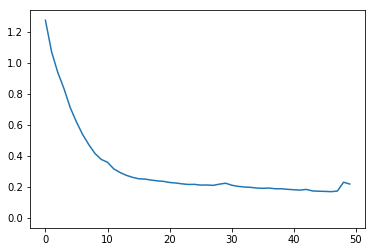

In [8]:
lowestloss = min(losses)
lowestval = min(valid_losses)
print(f'lowest train loss: {lowestloss}')
print(f'lowest valid loss: {lowestval}')
plt.plot(losses)
plt.plot(valid_losses)
plt.plot(np.linspace(0,30,1))
plt.show()

In [9]:
# model_file = 'models/model_feb252018_5:02.pkl'
# torch.save(unet, model_file)
# unet = torch.load(model_file)

# Examining Predictions

In [10]:
#make a less memory intensive inference dataloader (small batch size)
BATCH_SIZE_INF = 8
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
#     transforms.Grayscale(),
    transforms.ToTensor()
])


test_transform_size = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = YvanImageFolder(os.path.join(DATA_PATH, 'test_img'), test_transform)
test_loader = data.DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE_INF,
                             shuffle=False,
                             num_workers=1)


test_sizes = YvanImageFolder(os.path.join(DATA_PATH, 'test_img'), test_transform_size)
test_sizes_loader = data.DataLoader(dataset=test_sizes,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1)

In [11]:
predicted_masks = []
actual_masks = []
actual_imgs = []
names = []
for (batch, mask_batch, batch_name, mask_name) in img_loader:
    image_batch = to_variable(batch)
    labels = to_variable(mask_batch)
    names.extend(batch_name)
    x = unet(image_batch)
    for i, l, a in zip(x.data, labels.data, image_batch.data):
        actual_imgs.append(transforms.ToPILImage()(a.cpu()))
        predicted_masks.append(transforms.ToPILImage()(i.cpu()))
        actual_masks.append(transforms.ToPILImage()(l.cpu()))
        
assert len(predicted_masks) == len(actual_masks)
assert len(predicted_masks) == len(names)

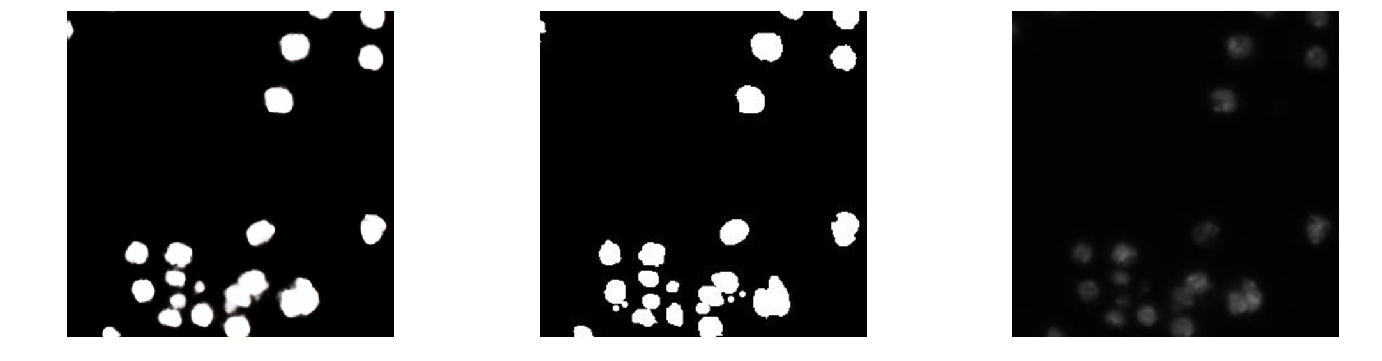

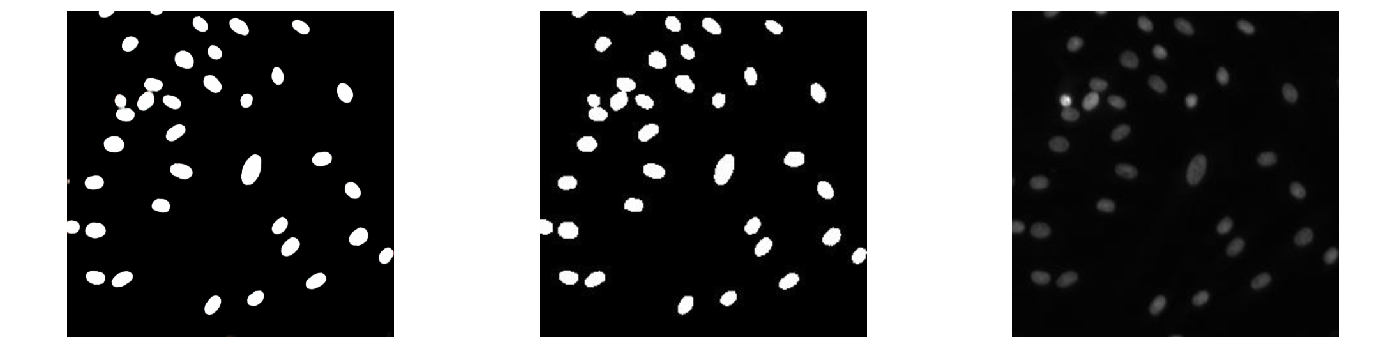

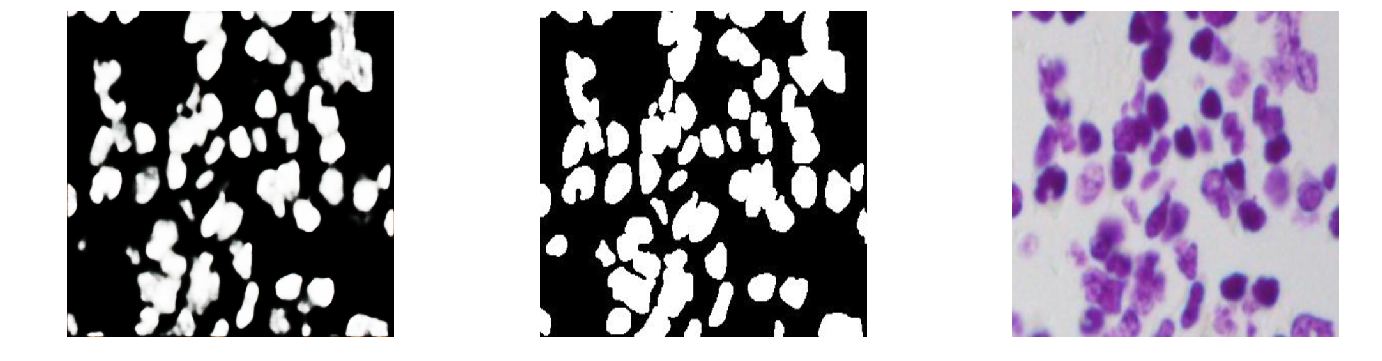

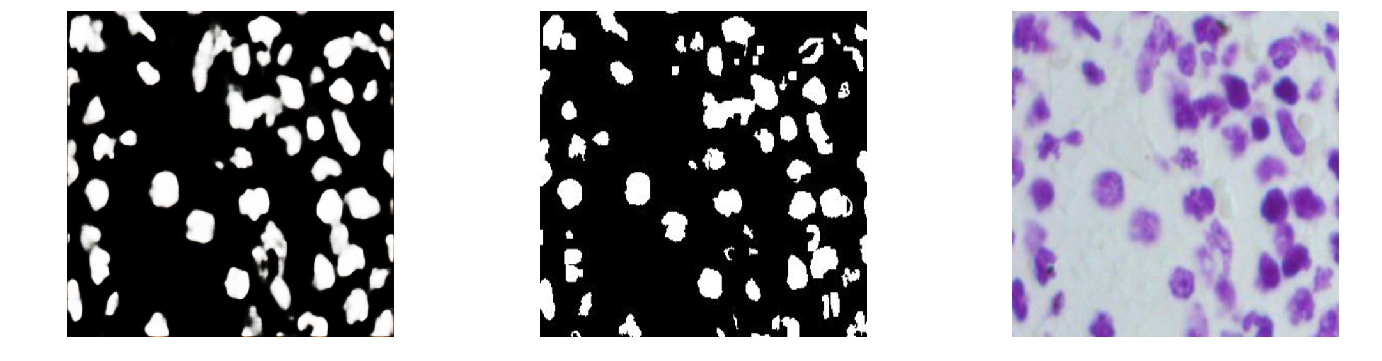

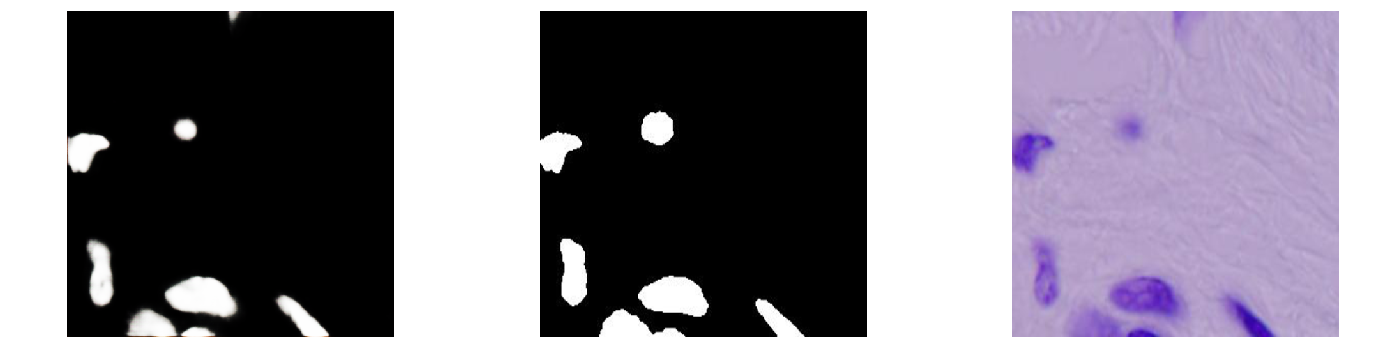

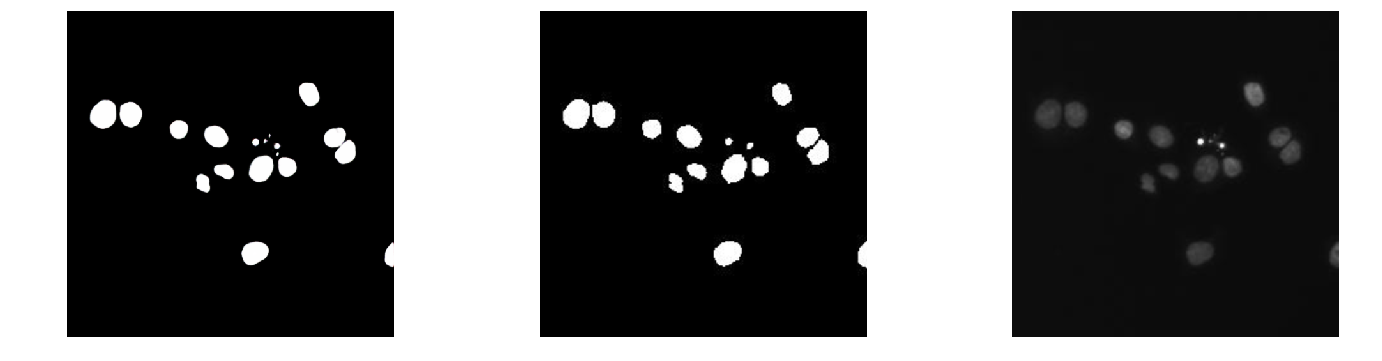

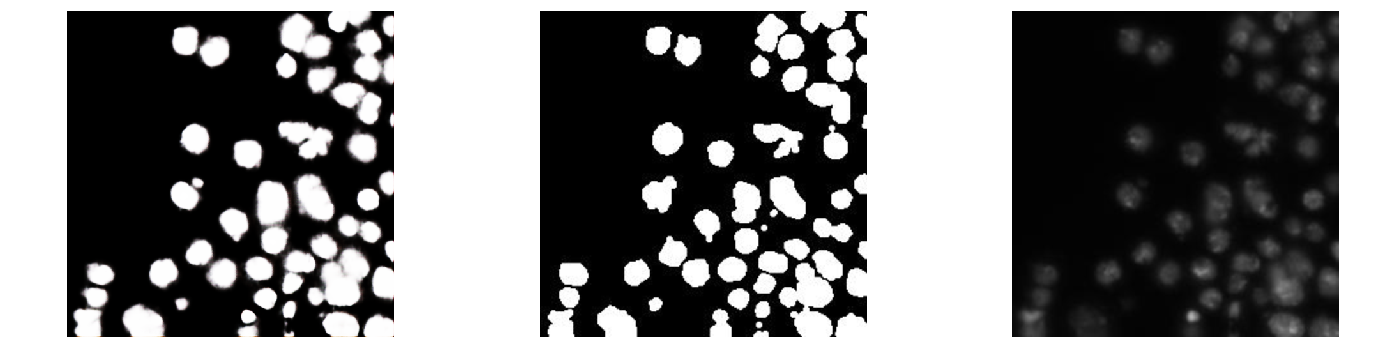

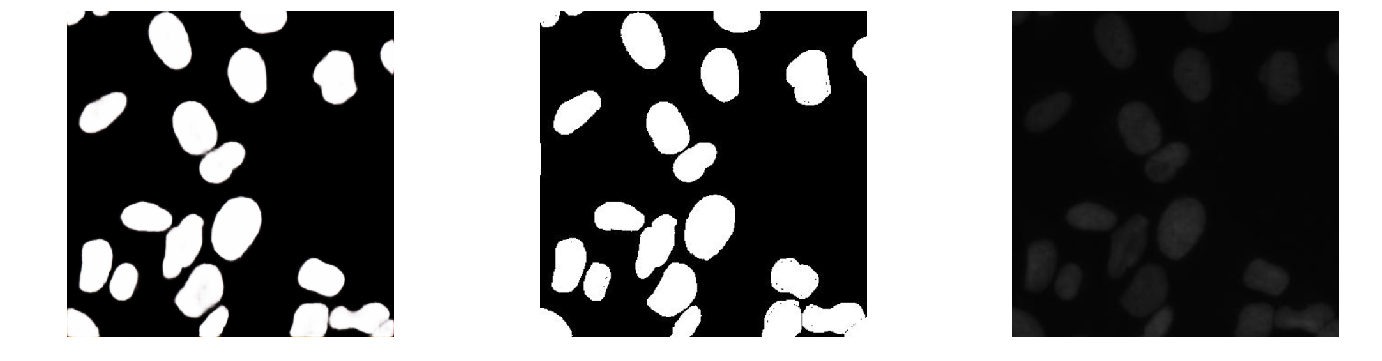

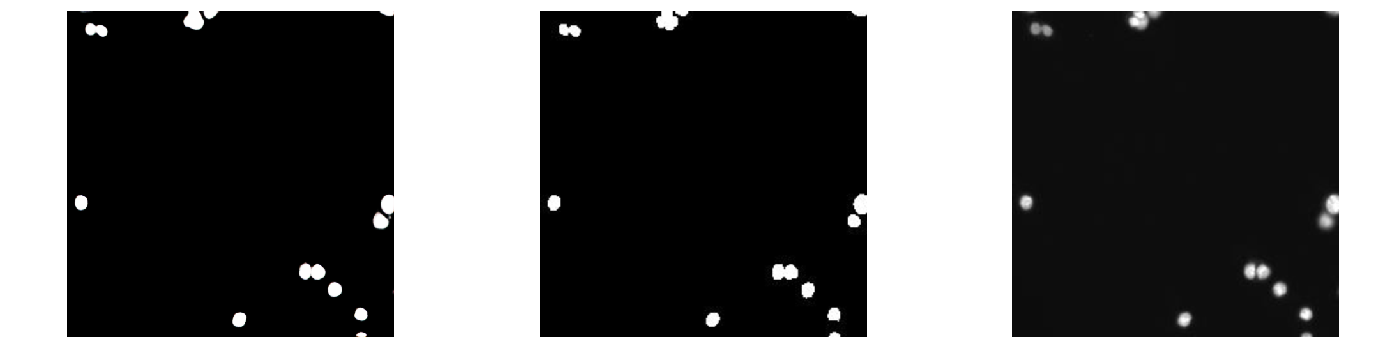

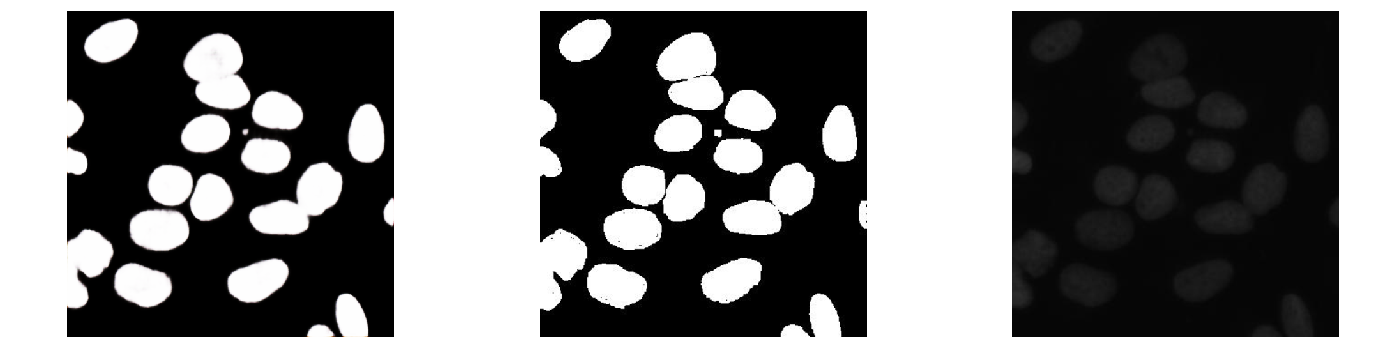

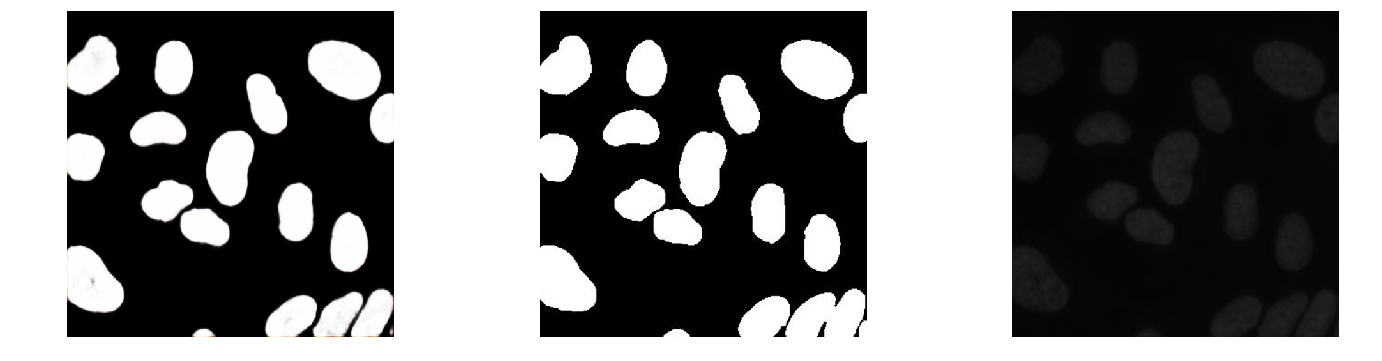

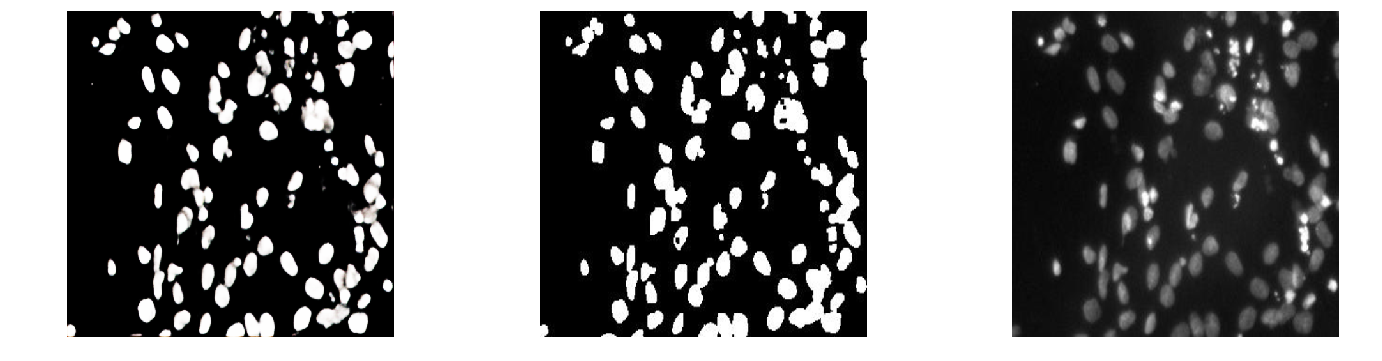

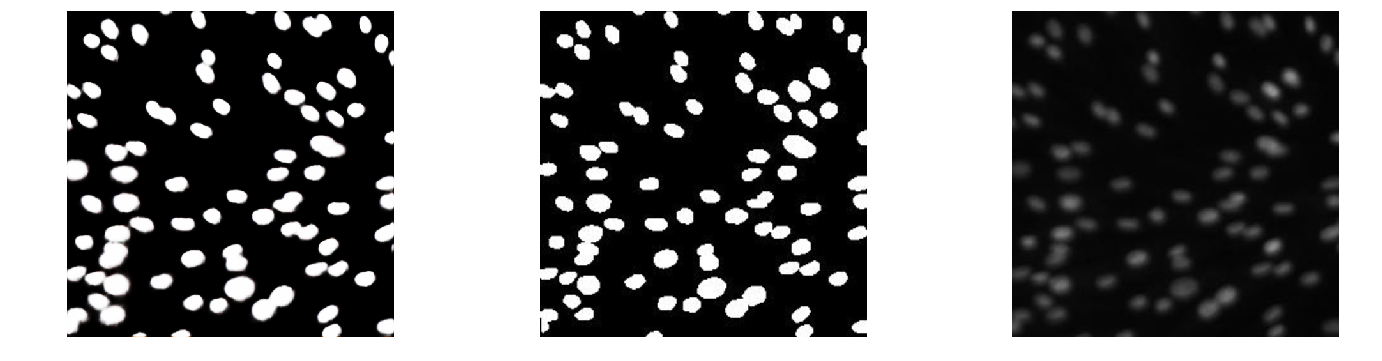

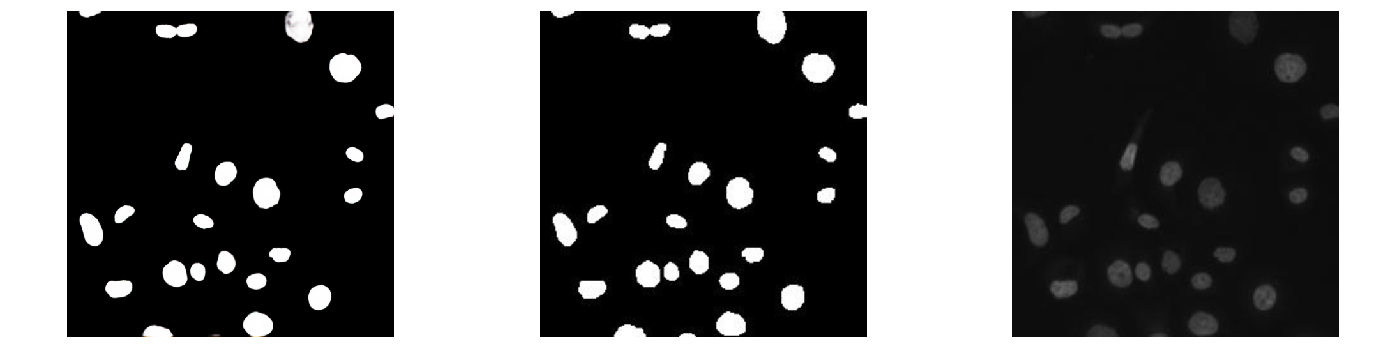

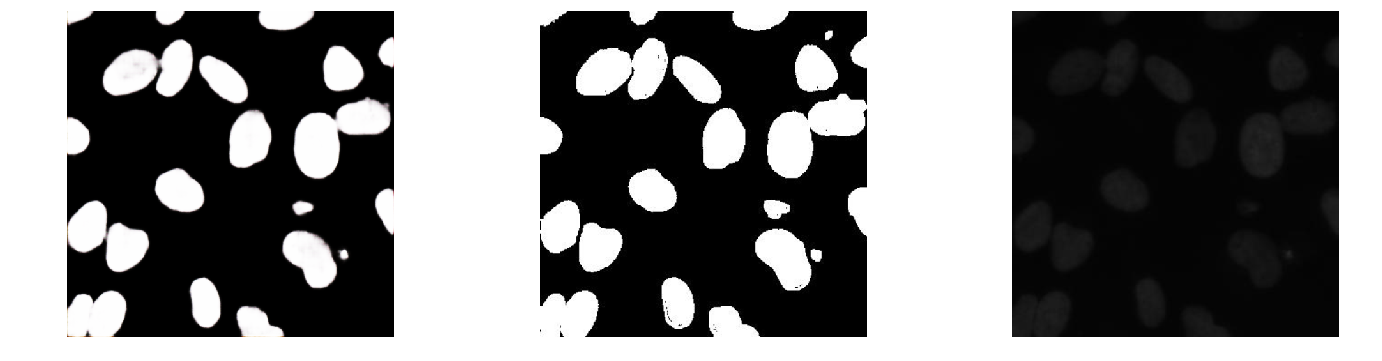

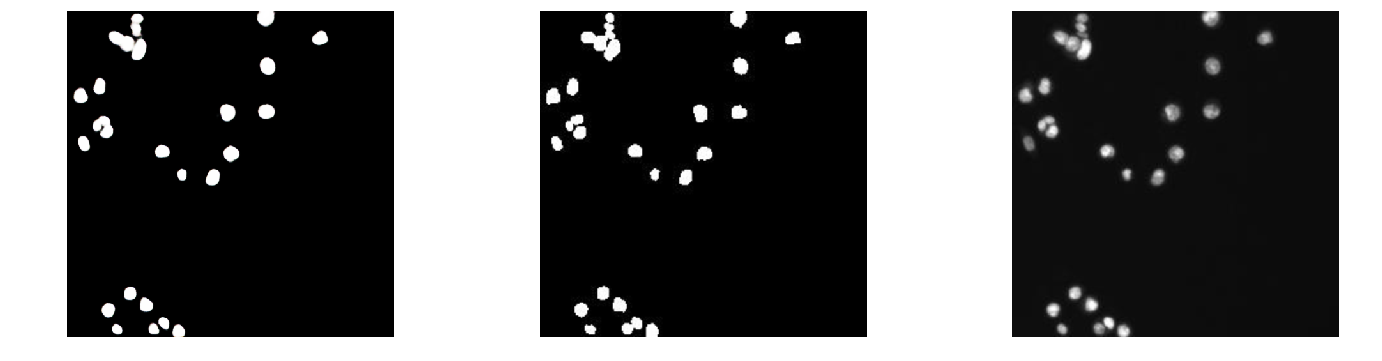

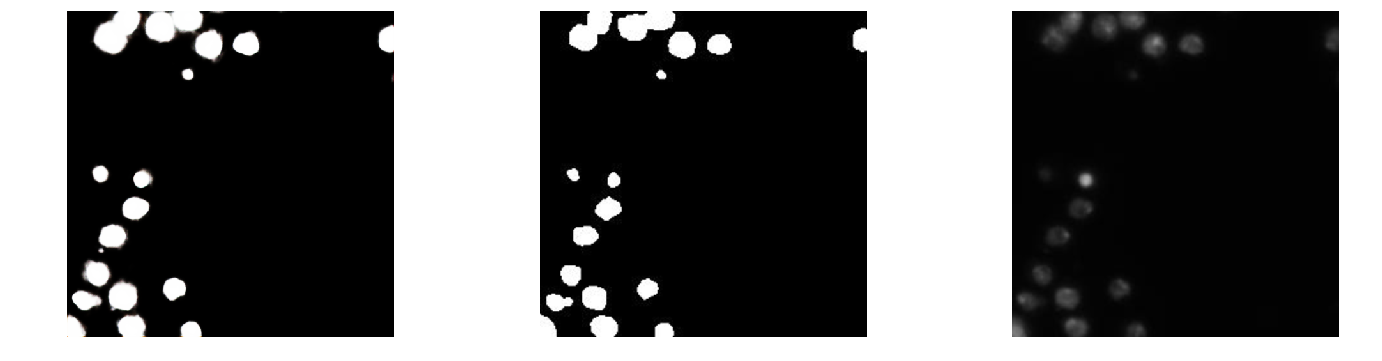

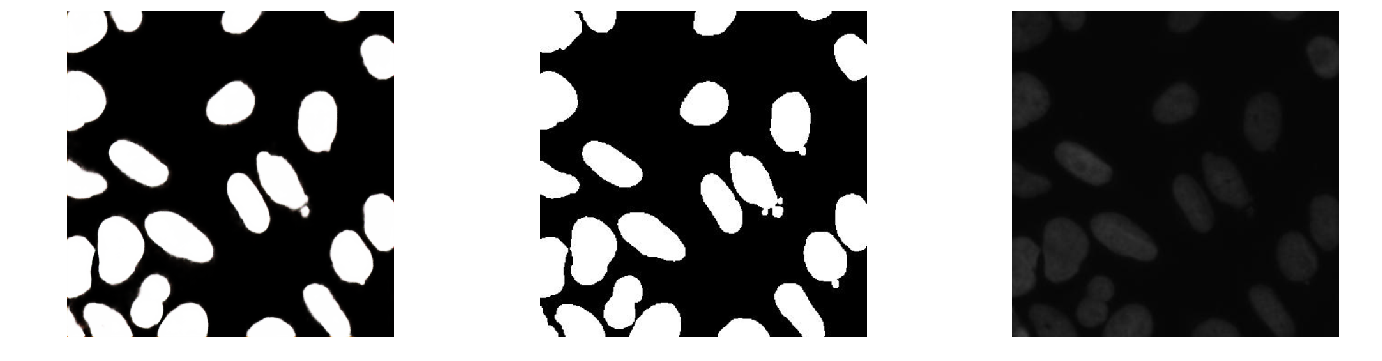

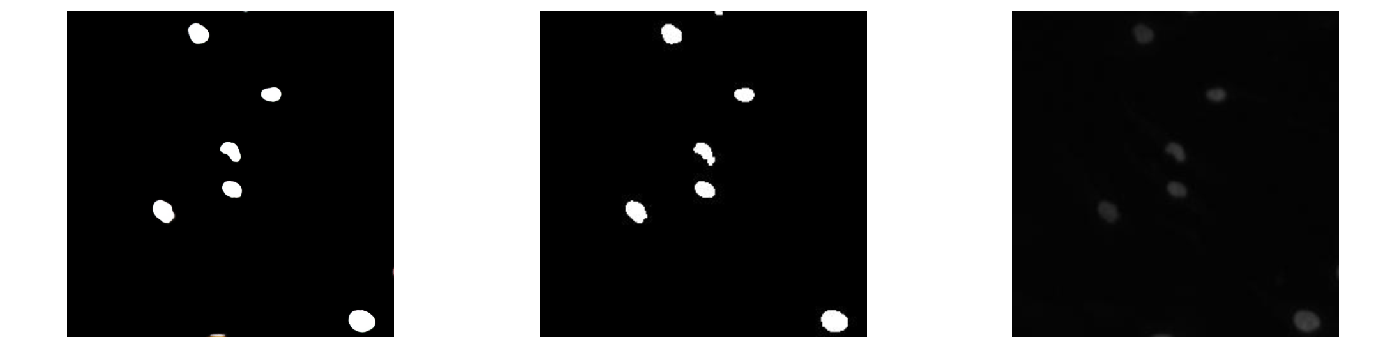

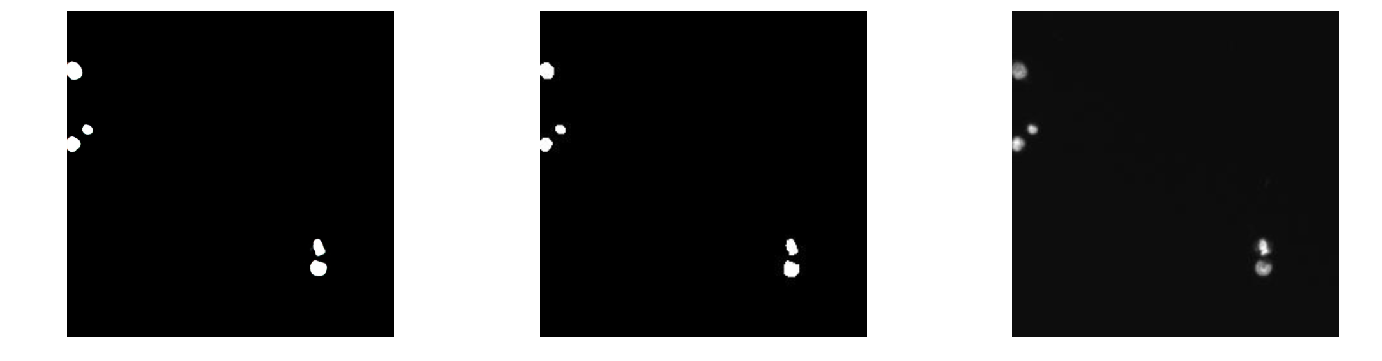

In [12]:
def show_n(img_files, n=6):
    _, ax = plt.subplots(1, n, sharex='col', sharey='row', figsize=(24,6))
    
    for i, img_file in enumerate(img_files):
        ax[i].imshow(img_file)
        ax[i].axis('off')
        
for pred,actual,img in zip(predicted_masks[:20], actual_masks[:20], actual_imgs[:20]):
    show_n([np.asarray(pred), np.asarray(actual), np.asarray(img)],n=3)

In [13]:
assert pred.mode == actual.mode, f'modes are wrong: {pred.mode}, {actual.mode}'

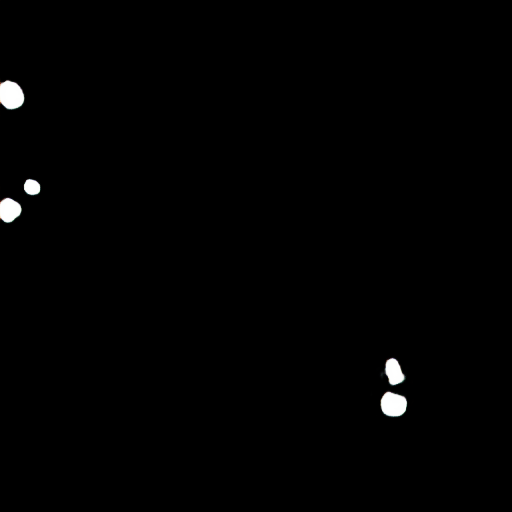

In [14]:
pred

# Generating test predictions

In [15]:
sizes_in_order = [tuple(batch[0].size()[2:]) for batch, paths in test_sizes_loader]

In [16]:
predicted_names = []
predicted_test = []
ct = 0

for batch, paths in test_loader:
    predicted_names += list(paths[0])
    image_batch = to_variable(batch[0])
    x = unet(image_batch)
    for i in x.data:
        size = sizes_in_order[ct]
        im = transforms.ToPILImage()(i.cpu())
        im = im.resize((size[1], size[0]), resample=Image.BICUBIC)
        predicted_test.append(im)
        ct += 1

In [17]:
for i in range(len(sizes_in_order)): 
    assert sizes_in_order[i] == np.asarray(predicted_test[i].convert('1')).shape

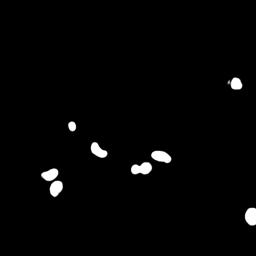

In [18]:
predicted_test[15]

# Make a submission

In [19]:
import pandas as pd

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

test_names = []
test_rles = [] 
for i, (p, path) in enumerate(zip(predicted_test, predicted_names)):
    supposed_size = sizes_in_order[i]
    pred_slide = np.asarray(np.array(p)/255)
    name = os.path.splitext(os.path.basename(path))[0].split('_')[0]
    rles = list(prob_to_rles(pred_slide))
    test_rles.extend(rles)
    test_names.extend([name]*len(rles))

In [20]:
sub = pd.DataFrame()
sub['ImageId'] = test_names
sub['EncodedPixels'] = pd.Series(test_rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.tail(n=15)

,ImageId,EncodedPixels
2897,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,25023 3 25277 7 25533 8 25788 9 26044 10 26299...
2898,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,21699 2 21953 5 22208 7 22462 9 22717 10 22972...
2899,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,9156 4 9411 6 9666 7 9921 8 10176 10 10431 11 ...
2900,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,19143 6 19398 8 19654 9 19910 9 20166 9 20422 ...
2901,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,27335 7 27590 9 27846 9 28102 9 28358 9 28614 ...
2902,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,30417 4 30671 8 30926 10 31181 12 31437 13 316...
2903,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,15320 6 15574 9 15830 10 16086 10 16342 11 165...
2904,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,26842 4 27096 8 27351 10 27606 11 27862 11 281...
2905,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,41437 2 41690 8 41946 9 42201 11 42457 12 4271...
2906,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,20965 6 21220 9 21476 10 21731 12 21987 13 222...


In [21]:
sub.to_csv(os.path.join(DATA_PATH, 'submissions','march12018_7.csv'), index=False)

Further reading: 

https://www.kaggle.com/c/noaa-fisheries-steller-sea-lion-population-count/discussion/35422

mask rcnn, mask ssd:

https://www.kaggle.com/c/data-science-bowl-2018/discussion/50428

https://www.kaggle.com/c/data-science-bowl-2018/discussion/50680

https://github.com/longcw/faster_rcnn_pytorch (no longer maintained)

https://github.com/ruotianluo/pytorch-faster-rcnn

**winners of caravana:**

http://blog.kaggle.com/2017/12/22/carvana-image-masking-first-place-interview/

https://arxiv.org/abs/1409.1556

https://github.com/asanakoy/kaggle_carvana_segmentation

caravana kernels: https://www.kaggle.com/c/carvana-image-masking-challenge/kernels

Best LB 0.279.